# EFFICIENTNETB0

In [2]:
from google.colab import files
uploaded = files.upload()

Saving data.zip to data.zip


## UPLOAD AND SPLIT DATA

In [3]:
import os
import shutil
import random
import zipfile

# ==========
# Giải nén data.zip trong Colab
# ==========
ZIP_PATH = "/content/data.zip"
EXTRACT_DIR = "/content/data"     # sau khi unzip xong -> /content/data/class_name
DEST_DIR = "/content/dataset"     # nơi chứa train/val/test

# Tỷ lệ chia
TRAIN_RATIO = 0.7
VAL_RATIO = 0.15
TEST_RATIO = 0.15

# Danh sách class
CLASSES = ["glass", "metal", "organic", "paper", "plastic", "trash"]

# -----------------------------
# Giải nén ZIP
# -----------------------------
def unzip_data():
    if not os.path.exists(EXTRACT_DIR):
        print("Unzipping data.zip ...")
        with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
            zip_ref.extractall("/content")
        print("Done unzip!")
    else:
        print("Folder already extracted.")

# -----------------------------
# Tạo thư mục dataset/train/val/test
# -----------------------------
def make_dirs():
    for split in ["train", "val", "test"]:
        for cls in CLASSES:
            os.makedirs(os.path.join(DEST_DIR, split, cls), exist_ok=True)

# -----------------------------
# Chia dữ liệu
# -----------------------------
def split_data():
    unzip_data()
    make_dirs()

    for cls in CLASSES:
        src_cls_dir = os.path.join(EXTRACT_DIR, cls)
        images = [f for f in os.listdir(src_cls_dir)
                  if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

        random.shuffle(images)
        n_total = len(images)

        n_train = int(n_total * TRAIN_RATIO)
        n_val = int(n_total * VAL_RATIO)
        n_test = n_total - n_train - n_val

        train_imgs = images[:n_train]
        val_imgs = images[n_train:n_train+n_val]
        test_imgs = images[n_train+n_val:]

        # Copy ảnh
        for img in train_imgs:
            shutil.copy(os.path.join(src_cls_dir, img),
                        os.path.join(DEST_DIR, "train", cls, img))

        for img in val_imgs:
            shutil.copy(os.path.join(src_cls_dir, img),
                        os.path.join(DEST_DIR, "val", cls, img))

        for img in test_imgs:
            shutil.copy(os.path.join(src_cls_dir, img),
                        os.path.join(DEST_DIR, "test", cls, img))

        print(f"[{cls}] Total: {n_total}, Train: {len(train_imgs)}, "
              f"Val: {len(val_imgs)}, Test: {len(test_imgs)}")

    print("Done! Dataset split completely.")

# -----------------------------
if __name__ == "__main__":
    split_data()


Unzipping data.zip ...
Done unzip!
[glass] Total: 536, Train: 375, Val: 80, Test: 81
[metal] Total: 622, Train: 435, Val: 93, Test: 94
[organic] Total: 761, Train: 532, Val: 114, Test: 115
[paper] Total: 647, Train: 452, Val: 97, Test: 98
[plastic] Total: 601, Train: 420, Val: 90, Test: 91
[trash] Total: 606, Train: 424, Val: 90, Test: 92
Done! Dataset split completely.


## PREPROCESS

In [4]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint


In [5]:
IMG_SIZE = 224
BATCH_SIZE = 16      # Quan trọng với EfficientNet
EPOCHS_HEAD = 5
EPOCHS_FINE = 20
NUM_CLASSES = 6

DATASET_DIR = "dataset"


In [6]:
# ----------------------------- Data Augmentation (Train) -----------------------------
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    # Chuẩn hóa ảnh theo đúng chuẩn của model pretrained (MobileNetV2 / EfficientNet)

    rotation_range=20,
    # Xoay ảnh ngẫu nhiên trong khoảng ±20 độ để tăng tính đa dạng dữ liệu

    zoom_range=0.2,
    # Phóng to / thu nhỏ ảnh ngẫu nhiên (±20%) giúp model học tốt hơn với các tỉ lệ khác nhau

    horizontal_flip=True
    # Lật ảnh theo chiều ngang ngẫu nhiên (phù hợp với nhiều bài toán ảnh)
)

# ----------------------------- Data Generator (Validation) -----------------------------
val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
    # Validation không dùng augmentation, chỉ chuẩn hóa ảnh
)

# ----------------------------- Train Generator -----------------------------
train_gen = train_datagen.flow_from_directory(
    DATASET_DIR + "/train",     # Thư mục chứa dữ liệu huấn luyện
    target_size=(IMG_SIZE, IMG_SIZE),
    # Resize ảnh về kích thước chuẩn của model

    batch_size=BATCH_SIZE,
    # Số ảnh trong mỗi batch

    class_mode="categorical",
    # Nhãn dạng one-hot (phù hợp với softmax + categorical_crossentropy)

    shuffle=True
    # Xáo trộn dữ liệu để tránh học theo thứ tự cố định
)

# ----------------------------- Validation Generator -----------------------------
val_gen = val_datagen.flow_from_directory(
    DATASET_DIR + "/val",       # Thư mục chứa dữ liệu validation
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",

    shuffle=False
    # Không shuffle để đảm bảo đánh giá ổn định và tái lập kết quả
)



Found 2638 images belonging to 6 classes.
Found 564 images belonging to 6 classes.


## TRAIN DATA

In [ ]:
# ----------------------------- Load pretrained backbone -----------------------------
base_model = EfficientNetB0(
    weights="imagenet",              # Sử dụng trọng số pretrained trên tập ImageNet
    include_top=False,               # Loại bỏ tầng phân loại gốc của EfficientNet
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
    # Kích thước ảnh đầu vào (RGB)
)

# Đóng băng toàn bộ backbone
# -> Chỉ huấn luyện các tầng phía trên (classification head)
base_model.trainable = False   # CHỈ TRAIN HEAD TRƯỚC


# ----------------------------- Build classification head -----------------------------
x = base_model.output
# Lấy feature map đầu ra từ EfficientNet

x = GlobalAveragePooling2D()(x)
# Giảm số chiều không gian (H x W) về vector 1D
# Giúp giảm số tham số và hạn chế overfitting

x = Dropout(0.4)(x)
# Dropout 40% để tăng khả năng tổng quát hóa của mô hình

output = Dense(
    NUM_CLASSES,
    activation="softmax"
)(x)
# Tầng fully connected cuối cùng
# Softmax dùng cho bài toán phân loại nhiều lớp


# ----------------------------- Final model -----------------------------
model = Model(
    inputs=base_model.input,
    outputs=output
)
# Mô hình hoàn chỉnh gồm:
# EfficientNetB0 (feature extractor) + classification head


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# ----------------------------- Callbacks -----------------------------
callbacks = [

    # Lưu lại model tốt nhất trong quá trình huấn luyện
    ModelCheckpoint(
        filepath="best_efficientnetb0.keras",
        # Đường dẫn lưu model có hiệu năng tốt nhất

        monitor="val_loss",
        # Theo dõi hàm mất mát trên tập validation

        save_best_only=True,
        # Chỉ lưu model khi val_loss giảm

        verbose=1
        # In thông báo khi model được lưu
    ),

    # Dừng huấn luyện sớm nếu model không còn cải thiện
    EarlyStopping(
        monitor="val_loss",
        # Theo dõi val_loss để quyết định dừng

        patience=7,
        # Cho phép 7 epoch không cải thiện trước khi dừng

        restore_best_weights=True
        # Khôi phục trọng số của epoch có val_loss thấp nhất
    ),

    # Giảm learning rate khi val_loss không giảm
    ReduceLROnPlateau(
        monitor="val_loss",
        # Theo dõi val_loss

        patience=3,
        # Nếu sau 3 epoch không cải thiện thì giảm learning rate

        factor=0.2
        # Learning rate mới = learning rate cũ × 0.2
    )
]


In [ ]:
# ----------------------------- Train classification head -----------------------------
print("===== TRAIN HEAD =====")
# Thông báo bắt đầu giai đoạn huấn luyện classification head

history_head = model.fit(
    train_gen,
    # Dữ liệu huấn luyện (đã được augmentation)

    epochs=EPOCHS_HEAD,
    # Số epoch cho giai đoạn train head
    # Backbone đã được freeze, chỉ cập nhật các tầng phía trên

    validation_data=val_gen,
    # Dữ liệu validation dùng để đánh giá trong quá trình huấn luyện

    callbacks=callbacks
    # Sử dụng các callback:
    # - ModelCheckpoint: lưu model tốt nhất
    # - EarlyStopping: dừng sớm nếu không cải thiện
    # - ReduceLROnPlateau: giảm learning rate khi cần
)


===== TRAIN HEAD =====


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2660 - loss: 1.7941
Epoch 1: val_loss improved from inf to 1.25237, saving model to best_efficientnetb0.keras
235/235 ━━━━━━━━━━━━━━━━━━━━ 475s 2s/step - accuracy: 0.2664 - loss: 1.7934 - val_accuracy: 0.6425 - val_loss: 1.2524 - learning_rate: 1.0000e-04
Epoch 2/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5895 - loss: 1.2353
Epoch 2: val_loss improved from 1.25237 to 0.94940, saving model to best_efficientnetb0.keras
235/235 ━━━━━━━━━━━━━━━━━━━━ 424s 2s/step - accuracy: 0.5896 - loss: 1.2350 - val_accuracy: 0.7573 - val_loss: 0.9494 - learning_rate: 1.0000e-04
Epoch 3/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6952 - loss: 0.9718
Epoch 3: val_loss improved from 0.94940 to 0.78912, saving model to best_efficientnetb0.keras
235/235 ━━━━━━━━━━━━━━━━━━━━ 439s 2s/step - accuracy: 0.6953 - loss: 0.9716 - val_accuracy: 0.7922 - val_loss: 0.7891 - learning_rate: 1.0000e-04
Epoch 4/5
235/235 ━━━━━━━━━━━━━━

In [ ]:
# ----------------------------- Fine-tuning backbone -----------------------------
base_model.trainable = True
# Mở khóa toàn bộ backbone để chuẩn bị fine-tuning

for layer in base_model.layers[:-30]:
    layer.trainable = False
    # Giữ nguyên (freeze) các layer đầu của backbone
    # Chỉ fine-tune ~30 layer cuối để tránh overfitting
    # và không phá vỡ các đặc trưng mức thấp đã học

# Compile lại model sau khi thay đổi trainable
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    # Learning rate nhỏ để fine-tuning ổn định

    loss="categorical_crossentropy",
    # Hàm mất mát cho bài toán phân loại nhiều lớp

    metrics=["accuracy"]
    # Đánh giá mô hình bằng độ chính xác
)


In [ ]:
# ----------------------------- Fine-tuning training -----------------------------
print("===== FINE-TUNING =====")
# Thông báo bắt đầu giai đoạn fine-tuning mô hình

history_fine = model.fit(
    train_gen,
    # Dữ liệu huấn luyện (có augmentation)

    epochs=EPOCHS_FINE,
    # Số epoch dành cho giai đoạn fine-tuning
    # Lúc này một phần backbone đã được mở khóa

    validation_data=val_gen,
    # Dữ liệu validation dùng để theo dõi khả năng tổng quát hóa

    callbacks=callbacks
    # Sử dụng lại các callback:
    # - ModelCheckpoint: lưu model tốt nhất trong quá trình fine-tuning
    # - EarlyStopping: tránh overfitting
    # - ReduceLROnPlateau: điều chỉnh learning rate khi cần
)


===== FINE-TUNING =====
Epoch 1/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7138 - loss: 0.9616
Epoch 1: val_loss did not improve from 0.62679
235/235 ━━━━━━━━━━━━━━━━━━━━ 498s 2s/step - accuracy: 0.7138 - loss: 0.9614 - val_accuracy: 0.8283 - val_loss: 0.6831 - learning_rate: 1.0000e-05
Epoch 2/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7480 - loss: 0.8492
Epoch 2: val_loss did not improve from 0.62679
235/235 ━━━━━━━━━━━━━━━━━━━━ 476s 2s/step - accuracy: 0.7481 - loss: 0.8491 - val_accuracy: 0.8384 - val_loss: 0.6330 - learning_rate: 1.0000e-05
Epoch 3/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7724 - loss: 0.7510
Epoch 3: val_loss improved from 0.62679 to 0.57083, saving model to best_efficientnetb0.keras
235/235 ━━━━━━━━━━━━━━━━━━━━ 475s 2s/step - accuracy: 0.7724 - loss: 0.7510 - val_accuracy: 0.8468 - val_loss: 0.5708 - learning_rate: 1.0000e-05
Epoch 4/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7791 - loss: 0.6867
Epoch 4: v

## ANALYSIS

In [7]:
from google.colab import files
uploaded = files.upload()

Saving best_efficientnetb0.keras to best_efficientnetb0.keras


Found 571 images belonging to 6 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


36/36 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.9061 - loss: 0.2502
Test Loss: 0.2573
Test Accuracy: 0.9107
36/36 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step


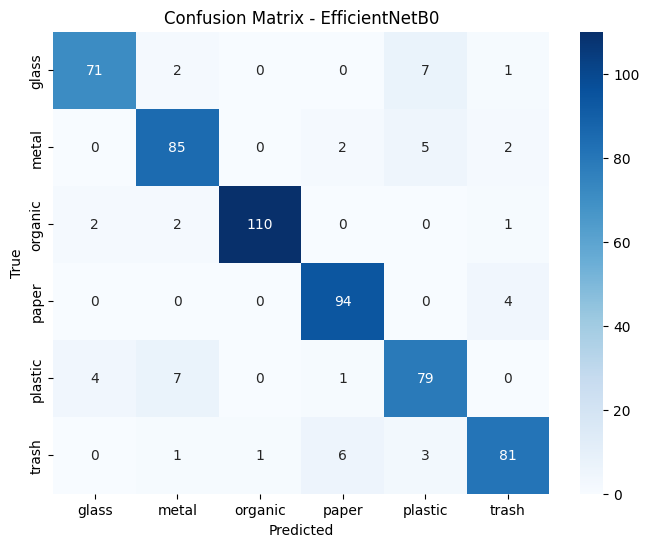

Classification Report:
              precision    recall  f1-score   support

       glass       0.92      0.88      0.90        81
       metal       0.88      0.90      0.89        94
     organic       0.99      0.96      0.97       115
       paper       0.91      0.96      0.94        98
     plastic       0.84      0.87      0.85        91
       trash       0.91      0.88      0.90        92

    accuracy                           0.91       571
   macro avg       0.91      0.91      0.91       571
weighted avg       0.91      0.91      0.91       571



In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input

# ----------------------------- Parameters -----------------------------
IMG_SIZE = 224              # Kích thước ảnh đầu vào
BATCH_SIZE = 16             # Batch size khi đánh giá
DATASET_DIR = "/content/dataset"


# ----------------------------- Test Data Generator -----------------------------
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
    # Chuẩn hóa ảnh theo đúng chuẩn EfficientNet
)

test_gen = test_datagen.flow_from_directory(
    DATASET_DIR + "/test",   # Thư mục chứa tập test
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False            # RẤT QUAN TRỌNG:
                              # Giữ nguyên thứ tự ảnh để
                              # so khớp đúng với nhãn thật khi vẽ confusion matrix
)


# ----------------------------- Load trained model -----------------------------
import tensorflow as tf

model = tf.keras.models.load_model("best_efficientnetb0.keras")
# Load model tốt nhất đã lưu trong quá trình huấn luyện


# ----------------------------- Evaluate on test set -----------------------------
test_loss, test_acc = model.evaluate(test_gen, verbose=1)
# Đánh giá model trên tập test

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")


# ----------------------------- Confusion Matrix & Classification Report -----------------------------
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Dự đoán xác suất cho từng lớp
y_pred = model.predict(test_gen)

# Chuyển xác suất sang nhãn dự đoán
y_pred_classes = np.argmax(y_pred, axis=1)

# Nhãn thật của tập test
y_true = test_gen.classes

# Tên các lớp
class_names = list(test_gen.class_indices.keys())


# ----------------------------- Confusion Matrix -----------------------------
cm = confusion_matrix(y_true, y_pred_classes)
# Tính ma trận nhầm lẫn

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,              # Hiển thị số lượng mẫu
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - EfficientNetB0")
plt.show()


# ----------------------------- Classification Report -----------------------------
print("Classification Report:")
print(
    classification_report(
        y_true,
        y_pred_classes,
        target_names=class_names
    )
)
# Hiển thị Precision, Recall, F1-score cho từng lớp
